# Plot model fits for simulation analysis 2

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from psifr import fr

from cymr import cmr
from dcmr import framework
from dcmr import figures
from dcmr import task

res_dir = Path(os.environ['CFR_RESULTS'])
fit_dir = Path(os.environ['CFR_FITS'])
fig_dir = Path(os.environ['CFR_FIGURES']) / 'sim2'

data_file = res_dir / 'cfr_eeg_mixed.csv'
patterns_file = res_dir / 'cfr_patterns.hdf5'
os.makedirs(fig_dir, exist_ok=True)
figures.set_style()

## Read observed and simulated data

In [2]:
patterns = cmr.load_patterns(patterns_file)
rsm = patterns['similarity']['use']

In [3]:
models = [
    'cmrs_fcf-loc-cat-use',
    'cmrs_fcf-loc-cat-use_sl-B_enc-B_rec_fix-B_rec_cat1-B_rec_use1',
]
model_names = [
    'DCMR',
    'DCMR-Focused',
]
data = framework.read_model_sims(data_file, fit_dir, models, model_names)

In [4]:
# for speed, omit simulation replications; comment out for final
# data = data.loc[data['list'] <= 48]

## Set colors

In [5]:
curve = sns.color_palette(
    'ch:rot=-.5, light=.6, dark=.3, gamma=1', n_colors=len(models)
)
curve.insert(len(models), (.3, .3, .3))
curve

[(0.44163916703794076, 0.6914342033666265, 0.5414714890673176),
 (0.17051215858853222, 0.344636926092434, 0.3959064384004337),
 (0.3, 0.3, 0.3)]

In [6]:
dark = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.6', n_colors=len(models)
)
dark.insert(len(models), (.6, .6, .6))
dark

[(0.725301473503126, 0.8645990769601404, 0.7363315007817791),
 (0.33145894574681245, 0.5393097642399239, 0.6005096167923277),
 (0.6, 0.6, 0.6)]

In [7]:
light = sns.color_palette(
    'ch:rot=-.5, light=.7, dark=.3, gamma=.2', n_colors=len(models)
)
light.insert(len(models), (.85, .85, .85))
light

[(0.8973525746116884, 0.9546730560357413, 0.901891392639006),
 (0.6820851323976215, 0.8225675908928259, 0.8639314200489312),
 (0.85, 0.85, 0.85)]

In [8]:
opt = {'height': 4, 'aspect': 1, 'palette': curve}

## Serial position effects

In [9]:
spc = data.groupby('source').apply(fr.spc)

LINO NOT subset; don't know how to subset; dropped


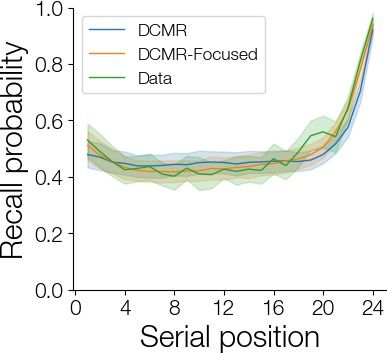

In [10]:
g = fr.plot_spc(spc, hue='source', height=4, aspect=1.1)
g.set(xticks=[0, 4, 8, 12, 16, 20, 24])
g.axes[0, 0].legend(fontsize='x-small')
g.savefig(fig_dir / 'spc_comp.pdf')

In [11]:
m = spc.groupby(["source", "input"])["recall"].mean().unstack("source")
framework.compare_fit(m)

,DCMR,DCMR-Focused
rmsd,0.044227,0.023454


In [12]:
pnr = data.groupby('source').apply(fr.pnr)
pnr["Output"] = pnr["output"]

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


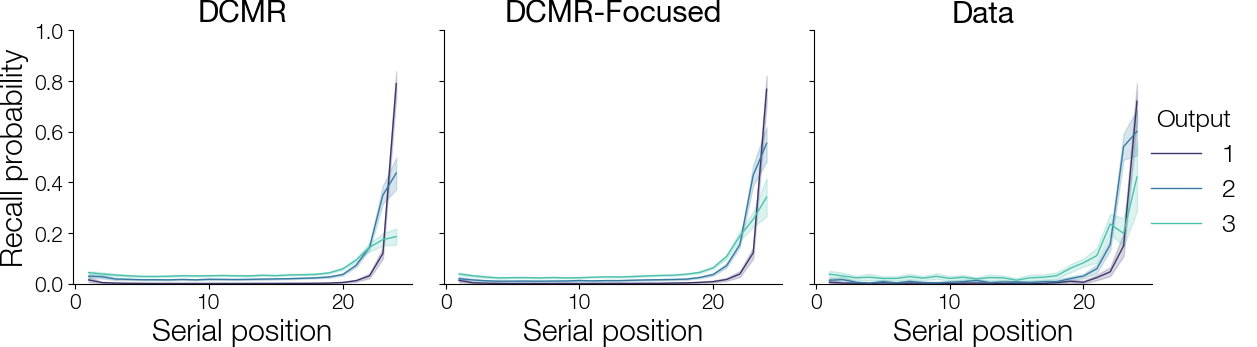

In [13]:
g = fr.plot_spc(
    pnr.query('output <= 3'), hue='Output', col='source', height=4, aspect=1, palette="mako"
).add_legend()
g.set_titles('{col_name}')
g.savefig(fig_dir / 'pnr.pdf');

In [14]:
m = (
    pnr.query("(input > 20) & (output <= 3)")
    .groupby(["source", "input", "output"])
    .mean()["prob"]
    .unstack("source")
)
m.groupby("output").apply(framework.compare_fit)

,,DCMR,DCMR-Focused
output,,,
1,rmsd,0.038818,0.027752
2,rmsd,0.126604,0.061466
3,rmsd,0.127147,0.054045


## Clustering measures

In [15]:
lag_rank_within = data.groupby('source').apply(
    fr.lag_rank, test_key='category', test=lambda x, y: x == y
)

LINO NOT subset; don't know how to subset; dropped


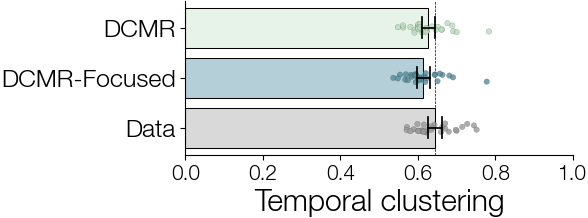

In [16]:
fig, ax = plt.subplots(figsize=(5, 2))
figures.plot_swarm_bar(
    lag_rank_within,
    y='source',
    x='rank',
    hue='source',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = lag_rank_within.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Temporal clustering', ylabel='');
fig.savefig(fig_dir / 'comp_lag_rank.pdf')

In [17]:
cat_crp = data.groupby('source').apply(
    fr.category_crp, category_key='category'
)

LINO NOT subset; don't know how to subset; dropped


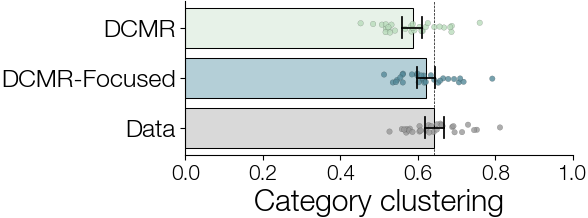

In [18]:
fig, ax = plt.subplots(figsize=(5, 2))
figures.plot_swarm_bar(
    cat_crp,
    y='source',
    hue='source',
    x='prob',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = cat_crp.loc['Data', 'prob'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Category clustering', ylabel='');
fig.savefig(fig_dir / 'comp_cat_crp.pdf')

In [19]:
use_rank = data.groupby('source').apply(
    fr.distance_rank, 'item_index', 1 - rsm, test_key='category',
    test=lambda x, y: x == y
)

LINO NOT subset; don't know how to subset; dropped


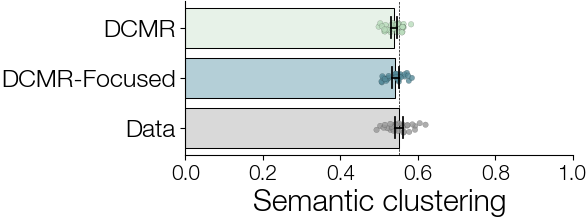

In [20]:
fig, ax = plt.subplots(figsize=(5, 2))
figures.plot_swarm_bar(
    use_rank,
    y='source',
    hue='source',
    x='rank',
    dark=dark,
    light=light,
    point_kind='strip',
    ax=ax,
)
ax.tick_params(axis='x', labelsize='small')
ax.tick_params(axis='y', labelsize='medium')
m = use_rank.loc['Data', 'rank'].mean()
ax.axline([m, 0], slope=np.inf, linestyle='--', linewidth=.5, color='k')
ax.set(xlim=(0, 1), xlabel='Semantic clustering', ylabel='');
fig.savefig(fig_dir / 'comp_use_rank.pdf')

## Shifted distance rank

In [21]:
distances = 1 - rsm
max_shift = 3
dist_rank = data.groupby('source').apply(
    fr.distance_rank_shifted, 
    'item_index', 
    distances, 
    max_shift, 
    test_key='category', 
    test=lambda x, y: x == y,
)

LINO NOT subset; don't know how to subset; dropped


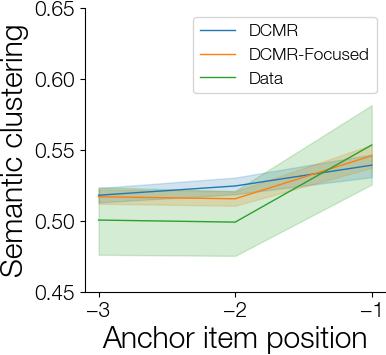

In [22]:
g = sns.relplot(
    data=dist_rank.reset_index(), 
    x='shift', 
    y='rank', 
    hue='source', 
    kind='line', 
    height=4,
    aspect=1.2,
)
ax = g.axes[0, 0]
g._legend.remove()
g.set(ylim=[.45, .65], ylabel='Semantic clustering', xlabel='Anchor item position')
ax.legend(fontsize='x-small')
g.savefig(fig_dir / 'use_rank_shifted_comp.pdf')

In [23]:
subs = dist_rank.loc['Data']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.137592,28,two-sided,0.891548,"[-0.02, 0.02]",0.02277,0.199,0.051609


In [24]:
subs = dist_rank.loc['DCMR']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.517262,28,two-sided,0.001507,"[0.0, 0.01]",0.436896,23.306,0.622332


In [25]:
subs = dist_rank.loc['DCMR-Focused']
shift_mat = pd.pivot(
    subs.reset_index(), index='subject', columns='shift', values='rank'
)
pg.ttest(shift_mat[-2], shift_mat[-3], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.597539,28,two-sided,0.55495,"[-0.01, 0.0]",0.102321,0.233,0.083047


In [26]:
m = dist_rank.groupby(["source", "shift"])["rank"].mean().unstack("source")
framework.compare_fit(m)

,DCMR,DCMR-Focused
rmsd,0.019642,0.014106


## Compound lag-CRP

In [27]:
crp = data.groupby('source').apply(
    fr.lag_crp_compound, test_key='category', test=lambda x, y: x == y
)
binned = crp.reset_index()
binned.loc[binned['previous'].abs() > 3, 'Previous'] = '|Lag|>3'
binned.loc[binned['previous'] == 1, 'Previous'] = 'Lag=+1'
binned.loc[binned['previous'] == -1, 'Previous'] = 'Lag=-1'
summed = binned.groupby(
    ['source', 'subject', 'Previous', 'current']
)[['actual', 'possible']].sum()
summed['prob'] = summed['actual'] / summed['possible']

In [28]:
pal = sns.color_palette([np.array([5, 113, 176]) / 256, np.array([202, 0, 32]) / 256, np.array([0.4, 0.4, 0.4])])
pal

[(0.01953125, 0.44140625, 0.6875), (0.7890625, 0.0, 0.125), (0.4, 0.4, 0.4)]

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


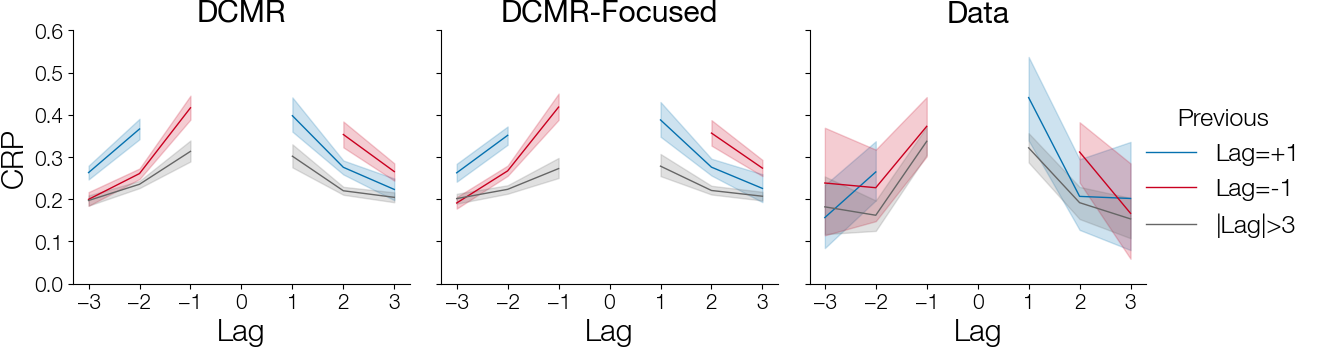

In [29]:
g = fr.plot_lag_crp(
    summed, lag_key='current', hue='Previous', col='source', height=4, max_lag=3, palette=pal
).add_legend()
g.set_titles(template='{col_name}')
g.set(ylim=[0, 0.6], xticks=[-3, -2, -1, 0, 1, 2, 3])
g.savefig(fig_dir / 'lag_crp_compound.pdf');

### Test for compound cuing in data

In [30]:
subs = summed.loc['Data']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.274438,27,two-sided,0.031101,"[0.01, 0.23]",0.429828,1.798,0.592181


In [31]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.937131,28,two-sided,0.356705,"[-0.04, 0.11]",0.174021,0.295,0.147867


### Test for compound cuing in DCMR

In [32]:
subs = summed.loc['DCMR']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.63337,28,two-sided,2.181001e-10,"[0.08, 0.12]",1.788872,4.769e+07,1.0


In [33]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,12.371435,28,two-sided,7.232797e-13,"[0.09, 0.12]",2.297318,1.076e+10,1.0


### Test for compound cuing in DCMR-Restricted

In [34]:
subs = summed.loc['DCMR-Focused']
p1 = subs.loc[:, 'Lag=+1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(p1[['prob']].query('current == 1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,10.357047,28,two-sided,4.411672e-11,"[0.09, 0.13]",1.923255,2.165e+08,1.0


In [35]:
n1 = subs.loc[:, 'Lag=-1', :] - subs.loc[:, '|Lag|>3', :]
pg.ttest(n1[['prob']].query('current == -1')['prob'], 0)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,13.968954,28,two-sided,3.818579e-14,"[0.12, 0.17]",2.59397,1.778e+11,1.0


In [36]:
m = (
    summed.query("(current >= -3) & (current <= 3)")
    .groupby(["source", "Previous", "current"])["prob"]
    .mean()
    .unstack("source")
)
m.groupby("Previous").apply(framework.compare_fit)

,,DCMR,DCMR-Focused
Previous,,,
Lag=+1,rmsd,0.075827,0.07337
Lag=-1,rmsd,0.056647,0.062236
|Lag|>3,rmsd,0.040775,0.048174


## Persistent recency lag-CRP

In [37]:
crpr = data.groupby("source").apply(task.crp_recency)

LINO NOT subset; don't know how to subset; dropped
LINO NOT subset; don't know how to subset; dropped


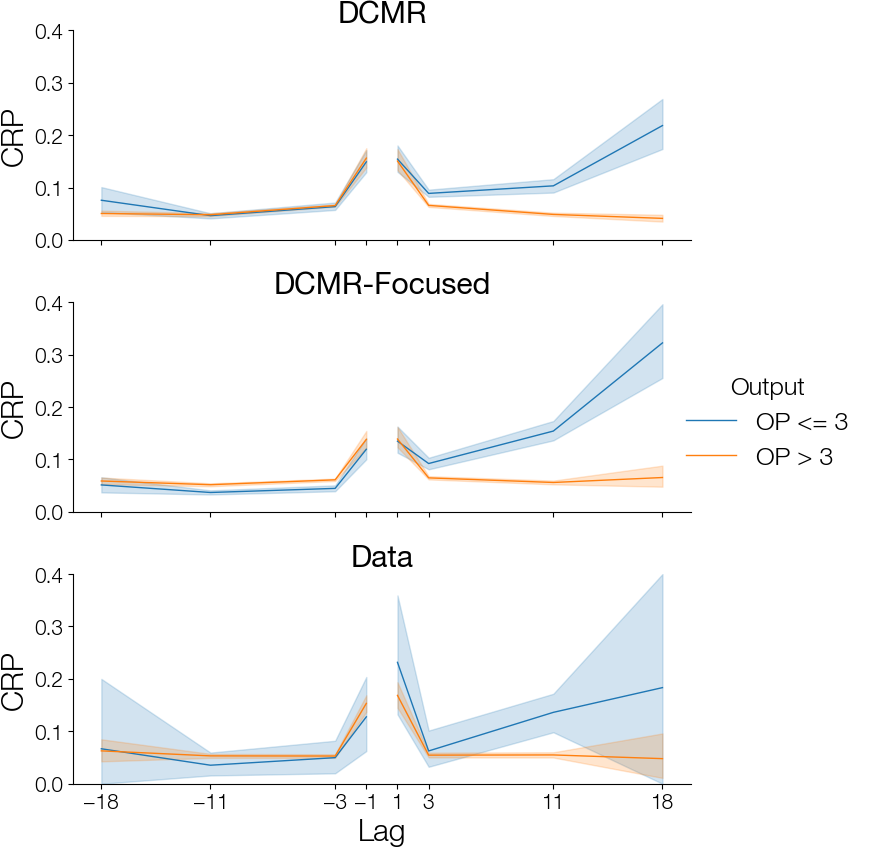

In [38]:
g = fr.plot_lag_crp(
    crpr, lag_key="Lag", max_lag=19, hue="Output", row="source", height=3, aspect=2.5
).set(ylim=(0, .4), xticks=[-18, -11, -3, -1, 1, 3, 11, 18]).add_legend()
g.set_titles(template='{row_name}');
g.savefig(fig_dir / "lag_crp_recency.pdf");

In [39]:
%load_ext watermark
%watermark -v -iv

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.2.0

dcmr      : 1.0.0a0
seaborn   : 0.13.2
numpy     : 2.1.3
cymr      : 0.12.2
pingouin  : 0.5.5
matplotlib: 3.10.3
psifr     : 0.9.3
pandas    : 2.2.3

